#### About

- Visualized age and diagnosed conditions through boxplots, and smoking status and urban living via barplots, identifying potential confounders.  
- Trained separate Light GBM models for treated and control groups to predict 1-year survival, highlighting the use of machine learning in causal inference.  
- Estimated Conditional Average Treatment Effect (CATE) using predictions from both models, showing the differential impact of treatment.  
- Applied the X-Learner approach to refine CATE estimates by imputing treatment effects and adjusting for confounders with propensity scores.  
- Compared CATE estimates from T-Learner and X-Learner methods to evaluate treatment effectiveness, emphasizing the benefits of advanced causal inference techniques.  

Importing Libraries 

In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor
import numpy as np
from sklearn.linear_model import LogisticRegression

sns.set(style="whitegrid")

#### Task 1: Data preliminary visualisation

In [112]:
train = pd.read_csv('treatment_biased.csv')
test = pd.read_csv('treatment_random.csv')
Y = "survived-1-year"
T = "treatment"
X = ["age", "diagnosed_condition", "smoker", "urban_living"]

In [113]:
test.head()

,age,diagnosed_condition,smoker,urban_living,treatment,survived-1-year
0,44.1,5483.80,0,1,0,0
1,39.8,2737.92,1,0,1,0
2,49.0,2712.51,1,1,1,1
3,39.7,2326.37,0,1,1,0
4,35.3,2787.26,0,1,1,0


##### Q1: For the training data only, plot the boxplot for i) age and ii) diagnosed_condition, both categorised by treated and control patients.

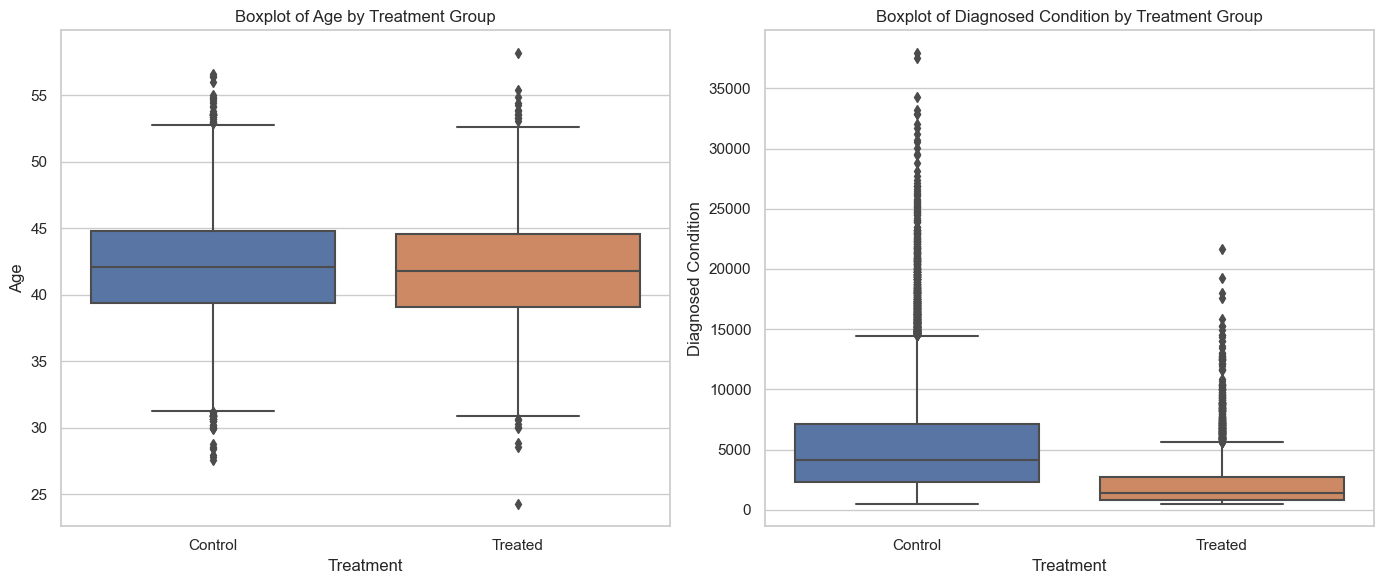

In [114]:
# Create a figure with 2 subplots (for age and diagnosed_condition) side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot for age categorized by treatment
sns.boxplot(x="treatment", y="age", data=train, ax=axes[0])
axes[0].set_title('Boxplot of Age by Treatment Group')
axes[0].set_xlabel('Treatment')
axes[0].set_ylabel('Age')
axes[0].set_xticklabels(['Control', 'Treated'])

# Boxplot for diagnosed_condition categorized by treatment
sns.boxplot(x="treatment", y="diagnosed_condition", data=train, ax=axes[1])
axes[1].set_title('Boxplot of Diagnosed Condition by Treatment Group')
axes[1].set_xlabel('Treatment')
axes[1].set_ylabel('Diagnosed Condition')
axes[1].set_xticklabels(['Control', 'Treated'])

plt.tight_layout()
plt.show()

For age, the median seems to be similar between the two groups, with a slightly wider IQR for treated patients, indicating greater variability in their ages.  
  
For diagnosed condition, both groups have a similar median, but the IQR for the treated group is more narrow, meaning its less variable in diagnosed condition scores among treated patients. There is a lot of extreme outliers in the treated group.

##### Q2: For the training data only, plot the barplot for i) the amount of smokers/non-smoker and ii) urban_living/ non_urban living, both categorised by treated and control patients.

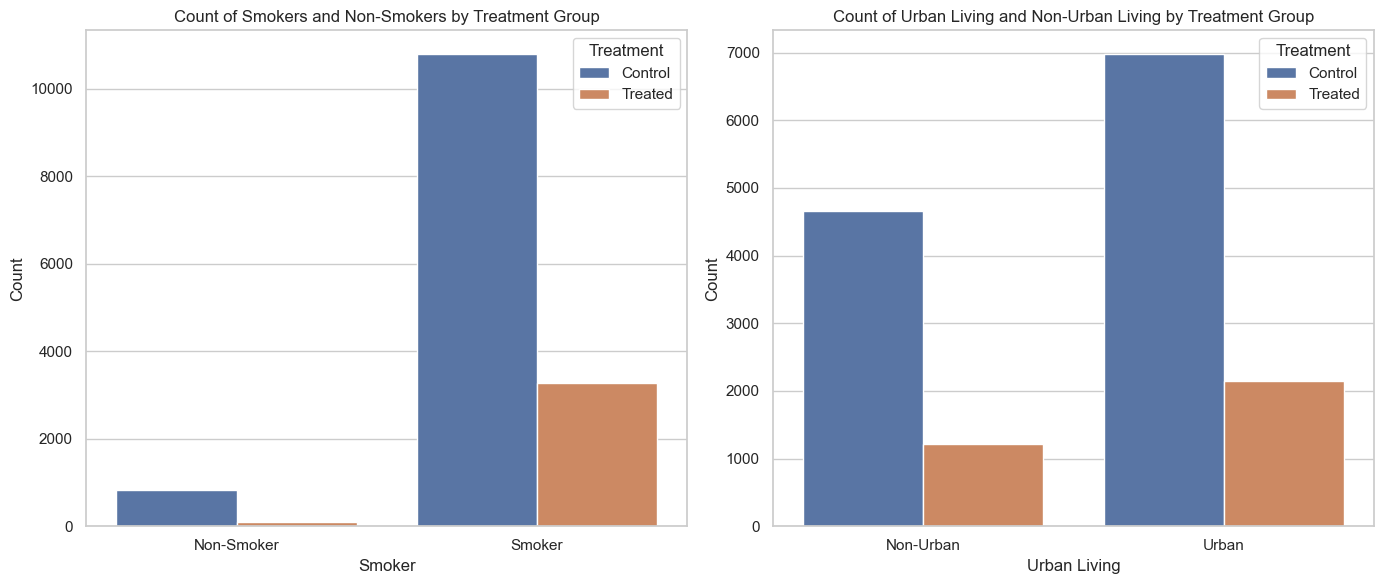

In [115]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Barplot for the amount of smokers/non-smokers categorized by treatment
sns.countplot(x='smoker', hue='treatment', data=train, ax=axes[0])
axes[0].set_title('Count of Smokers and Non-Smokers by Treatment Group')
axes[0].set_xlabel('Smoker')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Non-Smoker', 'Smoker'])
axes[0].legend(title='Treatment', labels=['Control', 'Treated'])

# Barplot for the urban living/non-urban living categorized by treatment
sns.countplot(x='urban_living', hue='treatment', data=train, ax=axes[1])
axes[1].set_title('Count of Urban Living and Non-Urban Living by Treatment Group')
axes[1].set_xlabel('Urban Living')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(['Non-Urban', 'Urban'])
axes[1].legend(title='Treatment', labels=['Control', 'Treated'])

# Show the plot
plt.tight_layout()
plt.show()

The majority of patients in both treated and control groups are non-smokers, with only a small proportion being smokers amd a significant majority of both treated and control patients reside in urban areas compared to non-urban areas

##### Q3: Comments whether those features can be identified as the potential confounding factors based on the preliminary visualisation.

The boxplots of age and diagnosed condition by treatment group do not show a major difference in median values between the treated and control groups, but there is variability in the interquartile ranges and the presence of outliers, particularly for the diagnosed condition, which suggests potential variability within groups which could be a confounding factor. The barplots for smoker status and urban living reveal significant differences in the counts of smokers and non-smokers and urban and non-urban residents when categorized by treatment group. These factors could also potentially confound the results as they are extremely unevenly distributed between the treated and control groups. 

#### Task 2: T-Learner

In [116]:
M0 = LGBMRegressor(max_depth=2, min_child_samples=60, verbose=-1)
M1 = LGBMRegressor(max_depth=2, min_child_samples=60, verbose=-1)

M0.fit(train.query(f"{T}==0")[X], train.query(f"{T}==0")[Y])
M1.fit(train.query(f"{T}==1")[X], train.query(f"{T}==1")[Y])

LGBMRegressor(max_depth=2, min_child_samples=60, verbose=-1)

##### Q1: Predict the treatment label by using all patients in test data for model 𝑀0 and 𝑀1.

In [117]:
# Q1: Predict the treatment label by using all patients in test data for model 𝑀0 and 𝑀1.
test["M0"] = M0.predict(test[X])
test["M1"] = M1.predict(test[X])
test[T] = (test["M1"] > test["M0"]).astype(int)

test.head()

,age,diagnosed_condition,smoker,urban_living,treatment,survived-1-year,M0,M1
0,44.1,5483.80,0,1,0,0,0.372957,0.369529
1,39.8,2737.92,1,0,1,0,0.101550,0.197628
2,49.0,2712.51,1,1,1,1,0.224324,0.418936
3,39.7,2326.37,0,1,1,0,0.218283,0.267120
4,35.3,2787.26,0,1,1,0,0.169142,0.235868


##### Q2: Estimate the CATE among patients {𝑖}in the test data such that

In [118]:
test["CATE"] = test["M1"] - test["M0"]
CATE_T_learner = test['CATE'].mean()

print(f"The CATE for the T-learner is {CATE_T_learner:.3f}")

The CATE for the T-learner is 0.077


#### Task 3: X-Learner

In [119]:
Z = np.where(train[T]==0, M1.predict(train[X]) - train[Y],  train[Y] - M0.predict(train[X]))

##### Q1: Complete the second stage model fitting for training data with imputed label 𝑍. Construct two LGBM regressors, one for treated patients 𝑀𝑇𝐴𝑈1, and another for control patients 𝑀𝑇𝐴𝑈0. For each model, fit the training data with imputed label 𝑍 instead of 𝑌.

In [120]:
MTAU0 = LGBMRegressor(max_depth=2, min_child_samples=60, verbose=-1)
MTAU1 = LGBMRegressor(max_depth=2, min_child_samples=60, verbose=-1)

# For the control group
MTAU0.fit(train.query(f"{T}==0")[X], Z[train[T]==0])

# For the treated group
MTAU1.fit(train.query(f"{T}==1")[X], Z[train[T]==1])

LGBMRegressor(max_depth=2, min_child_samples=60, verbose=-1)

##### Q2: For each model, make prediction for features in the test data (denoted as Ƹ𝜏0 =𝑀𝑇𝐴𝑈0(𝑋)and Ƹ𝜏1 = 𝑀𝑇𝐴𝑈1(𝑋)in the diagram).

In [121]:
test["eTau0"] = MTAU0.predict(test[X])
test["eTau1"] = MTAU1.predict(test[X])

test.head()

,age,diagnosed_condition,smoker,urban_living,treatment,survived-1-year,M0,M1,CATE,eTau0,eTau1
0,44.1,5483.80,0,1,0,0,0.372957,0.369529,-0.003428,-0.021045,0.035764
1,39.8,2737.92,1,0,1,0,0.101550,0.197628,0.096078,0.100582,0.091965
2,49.0,2712.51,1,1,1,1,0.224324,0.418936,0.194612,0.093383,0.163448
3,39.7,2326.37,0,1,1,0,0.218283,0.267120,0.048838,0.021599,0.030918
4,35.3,2787.26,0,1,1,0,0.169142,0.235868,0.066726,0.071248,0.025647


In [122]:
# propensity score model

g = LogisticRegression(solver="lbfgs", penalty=None, max_iter=500)
g.fit(train[X], train[T])

LogisticRegression(max_iter=500, penalty=None)

##### Q3: Estimate the propensity score 𝑒 by the prediction of model g on features 𝑋 in the test data, such that e = g(X)

In [123]:
test['e'] = g.predict_proba(test[X])[:, 1]  # Probability estimates for T=1

test.head()

,age,diagnosed_condition,smoker,urban_living,treatment,survived-1-year,M0,M1,CATE,eTau0,eTau1,e
0,44.1,5483.80,0,1,0,0,0.372957,0.369529,-0.003428,-0.021045,0.035764,0.092649
1,39.8,2737.92,1,0,1,0,0.101550,0.197628,0.096078,0.100582,0.091965,0.268055
2,49.0,2712.51,1,1,1,1,0.224324,0.418936,0.194612,0.093383,0.163448,0.266578
3,39.7,2326.37,0,1,1,0,0.218283,0.267120,0.048838,0.021599,0.030918,0.291424
4,35.3,2787.26,0,1,1,0,0.169142,0.235868,0.066726,0.071248,0.025647,0.257536


##### Q4: Estimate the CATE by the average of Ƹ𝜏0 and Ƹ𝜏1 weighted by the estimated propensity score Ƹ𝑒, such that 𝐶𝐴𝑇𝐸=𝑚𝑒𝑎𝑛( Ƹ𝑒 Ƹ𝜏0 + 1− Ƹ𝑒 Ƹ𝜏1

In [124]:
test['CATE_estimated'] = test['e'] * test['eTau0'] + (1 - test['e']) * test['eTau1']
CATE_X_learner = test['CATE_estimated'].mean()

print(f"The CATE for the X-learner is {CATE_X_learner:.3f}")

The CATE for the X-learner is 0.086


##### Q5: By comparing two CATE estimate from T-learner and X-learner, is there a significant difference by  utilising the two-stage model structure in the X-learner? Consider the value of CATE, can you comment on the effect of treatment to the survival given features X.

The CATE estimate from the X-learner is 0.086, and the CATE estimate from the T-learner is 0.077. The difference between these two estimates is  0.086 − 0.077 = 0.009. This represents a difference in the estimated average treatment effect of the two methods. Both learning methods suggest that the treatment is beneficial as the values are positive, according to these models, patients receiving the treatment are more likely to survive one year compared to those not receiving the treatment. The difference in their CATE estimates is quite small. 

#### Reflection & Summary

- Need to learn further about the CATE formulas  
- Learn more techniques to see which learning method is better even if the difference in CATE is small ( I read there are possible techniques)  